# Labor 08 - Lineáris regresszió regularizálása és Bias - Variancia
### Vízfolyás
A feladat első felében implementálásra kerül egy lineáris regresszió, hogy előre jelezhessük a kifolyt víz mennyiségét egy tartályból, annak alapján, hogy abban mennyi víz van. A feladat második felében megfigyeljük a tanulóalgoritmusok debuggolását és a bias illetve variancia típusú hibákat.

### 1: Importálás, adatok betöltése és vizualizálása

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as op

# keras imports for the dataset and building our neural network
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras import regularizers
from keras import optimizers


from numpy.random import seed
seed(1)

data = loadmat("Lab8data.mat")                          # adatok betöltése
X_test = data["X"]                                     # adatok szerkesztése változókba
Y_test = data["y"]
X_val   = data["Xval"]
Y_val   = data["yval"]
X_train  = data["Xtest"]
Y_train  = data["ytest"]

del data
m,n = X_train.shape
print('Shape of X:', X_train.shape)
print('Shape of Y:', Y_train.shape)

Using TensorFlow backend.


Shape of X: (21, 1)
Shape of Y: (21, 1)


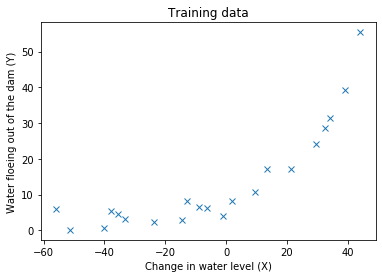

In [2]:
plt.plot(X_train,Y_train,'x')   # adatok megjelenítése
plt.title('Training data')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water floeing out of the dam (Y)')
plt.show()

A machine learning addig tart, ahol a deep learning elkezdődik. A határ az egy rétegű neurális háló.

### Linearizált regresszió büntetéssel

In [3]:
Lambda = 0
lr_rate = 0.001
epoch = 40

# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(1, input_shape=(1,), use_bias=True, kernel_regularizer=regularizers.l2(Lambda)))

# compiling the sequential model
sgd = optimizers.SGD(lr=lr_rate)
model.compile(loss='MSE', optimizer=sgd)

# training the model and saving metrics in history
history = model.fit(X_train, Y_train, epochs=epoch, validation_data=(X_val, Y_val), verbose = 2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 21 samples, validate on 21 samples
Epoch 1/40
 - 0s - loss: 765.3959 - val_loss: 556.5465
Epoch 2/40
 - 0s - loss: 643.2556 - val_loss: 551.4390
Epoch 3/40
 - 0s - loss: 551.8754 - val_loss: 414.8636
Epoch 4/40
 - 0s - loss: 483.4542 - val_loss: 427.2555
Epoch 5/40
 - 0s - loss: 432.1689 - val_loss: 337.3401
Epoch 6/40
 - 0s - loss: 393.6738 - val_loss: 355.5286
Epoch 7/40
 - 0s - loss: 364.7252 - val_loss: 295.0230
Epoch 8/40
 - 0s - loss: 342.9024 - val_loss: 313.4912
Epoch 9/40
 - 0s - loss: 326.3987 - val_loss: 271.9208
Epoch 10/40
 - 0s - loss: 313.8658 - val_loss: 288.3442
Epoch 11/40
 - 0s - loss: 304.2971 - val_loss: 259.2280
Epoch 12/40
 - 0s - loss: 296.9418 - val_loss: 272.8700
Epoch 13/40
 - 0s - loss: 291.2390 - val_loss: 252.1154
Epoch 14/40
 - 0s - loss: 286.7706 - val_loss: 262.9828
Epoch 15/40
 - 0s - loss: 283.2242 - val_loss: 247.9496
Epoch

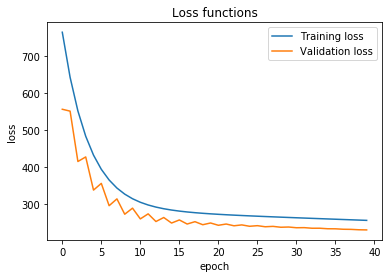

In [4]:
# plotting the metrics
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss functions')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'])

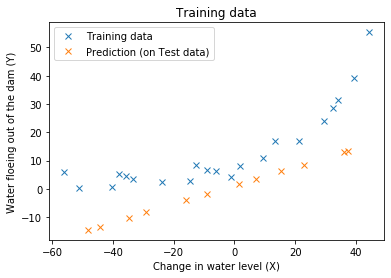

In [5]:
Y_pred = model.predict(X_test)

plt.plot(X_train,Y_train,'x')   # adatok megjelenítése
plt.plot(X_test,Y_pred,'x')   # adatok megjelenítése
plt.title('Training data')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water floeing out of the dam (Y)')
plt.legend(['Training data', 'Prediction (on Test data)'])
plt.show()

# Poly Feature

In [6]:
def polyFeatures(X,p =9):
    
    m=X.shape[0]
    X_poly = np.zeros((m,p))
    
    for i in range(1,m+1):
        for j in range(1,p+1):
            X_poly[i-1,j-1] = X[i-1]**j
    
    return X_poly

def featureNormalize(X):
    
    avg = np.mean(X, axis = 0)
    X_norm = X-avg
    std = np.std(X_norm, axis = 0,ddof = 1)
    X_norm = X_norm/std
    
    return X_norm,avg,std

In [7]:
Lambda = 0.001
lr_rate = 0.01
epoch = 30
order=9

In [8]:
# X:
X_train_p = polyFeatures(X_train, order)                                # polynomial features
X_train_pn, mu, sigma = featureNormalize(X_train_p)                     # feature normalization

# X_val:
X_val_p = polyFeatures(X_val, order)
X_val_pn = (X_val_p-mu)/sigma

# X_TESZT:
X_test_p = polyFeatures(X_test, order)
X_test_pn = (X_test_p-mu)/sigma

print("""Expected Normalized Training Example for order=3 (approx.):
[-0.362 -0.755  0.182 ]""")
print('Normalized Training Example 1:\n',X_train_pn[0,:])

Expected Normalized Training Example for order=3 (approx.):
[-0.362 -0.755  0.182 ]
Normalized Training Example 1:
 [-0.9296276   0.19880974 -0.4045469  -0.15939636 -0.01312719 -0.29085343
  0.16671663 -0.31824532  0.23591308]


In [9]:
# building a linear stack of layers with the sequential model
model2 = Sequential()
model2.add(Dense(order, input_shape=(order,), use_bias=True, kernel_regularizer=regularizers.l2(Lambda)))
model2.add(Dense(1))

# compiling the sequential model
sgd = optimizers.SGD(lr=lr_rate)
model2.compile(loss='MSE', optimizer=sgd)

# training the model and saving metrics in history
history2 = model2.fit(X_train_pn, Y_train, epochs=epoch, validation_data=(X_val_pn, Y_val), verbose = 2)

Train on 21 samples, validate on 21 samples
Epoch 1/30
 - 0s - loss: 378.6748 - val_loss: 276.5738
Epoch 2/30
 - 0s - loss: 330.1140 - val_loss: 226.6941
Epoch 3/30
 - 0s - loss: 279.4474 - val_loss: 166.3671
Epoch 4/30
 - 0s - loss: 216.8239 - val_loss: 102.5317
Epoch 5/30
 - 0s - loss: 144.4882 - val_loss: 48.7700
Epoch 6/30
 - 0s - loss: 74.4172 - val_loss: 17.8389
Epoch 7/30
 - 0s - loss: 27.4460 - val_loss: 10.1262
Epoch 8/30
 - 0s - loss: 9.2740 - val_loss: 10.9021
Epoch 9/30
 - 0s - loss: 5.3337 - val_loss: 11.9654
Epoch 10/30
 - 0s - loss: 4.5923 - val_loss: 11.7476
Epoch 11/30
 - 0s - loss: 4.3317 - val_loss: 12.4536
Epoch 12/30
 - 0s - loss: 4.2073 - val_loss: 11.2869
Epoch 13/30
 - 0s - loss: 4.2144 - val_loss: 13.3685
Epoch 14/30
 - 0s - loss: 4.4486 - val_loss: 10.4730
Epoch 15/30
 - 0s - loss: 5.1994 - val_loss: 16.5053
Epoch 16/30
 - 0s - loss: 7.1038 - val_loss: 10.1197
Epoch 17/30
 - 0s - loss: 11.9826 - val_loss: 27.4015
Epoch 18/30
 - 0s - loss: 22.5848 - val_loss: 1

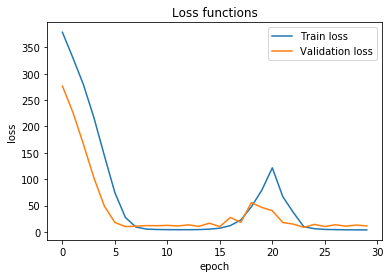

In [10]:
# plotting the metrics
fig = plt.figure()
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss functions')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'])

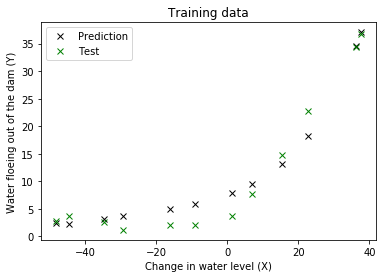

In [13]:
Y_pred2 = model2.predict(X_test_pn)

#plt.plot(X_train,Y_train,'x')   # adatok megjelenítése
plt.plot(X_test,Y_pred2,'x', color="black") 
plt.plot(X_test,Y_test,'x', color="green") 
plt.title('Training data')
plt.xlabel('Change in water level (X)')
plt.ylabel('Water floeing out of the dam (Y)')
plt.legend(['Prediction', 'Test'])
plt.show()